In [18]:
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import GRU
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import keras
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

In [19]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '../dataset/UCI_HAR_Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '../dataset/UCI_HAR_Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [20]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [21]:
# 특성 분포를 시각화하는 보조 함수
def plot_distributions(trainX):
    # 중복 부분을 제거합니다.
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # 시계열 데이터를 2D 배열로 변환합니다.
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    print(longX.shape)
    # 새로운 그림을 생성합니다.
    pyplot.figure()
    xaxis = None
    # 각 특성에 대한 루프를 실행합니다.
    for i in range(longX.shape[1]):
        # 현재 특성에 대한 하위 플롯을 생성합니다.
        ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
        # x 축의 범위를 설정합니다.
        ax.set_xlim(-1, 1)
        # 첫 번째 특성인 경우 x 축을 설정합니다.
        if i == 0:
            xaxis = ax
        # 현재 특성의 히스토그램을 그립니다.
        pyplot.hist(longX[:, i], bins=100)
    # 그림을 화면에 출력합니다.
    pyplot.show()


(470528, 9)


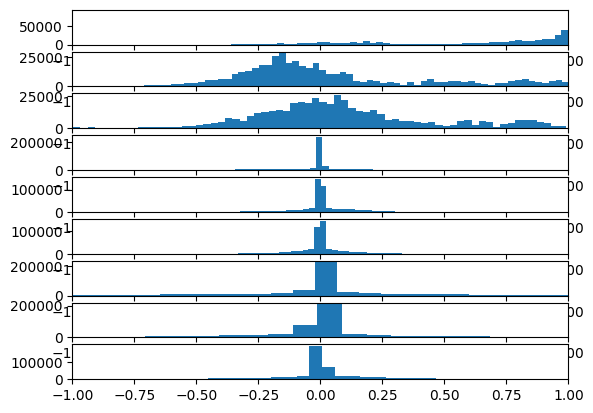

In [22]:
# 특성 분포 시각화를 위한 함수 호출
plot_distributions(trainX)

# BiLSTM

In [23]:
batch_size = 64 # 미니배치 크기 설정
validation_split = 0.2 # 검증 데이터 비율 설정 (20%는 검증 데이터로 사용)

In [24]:
# 모델 입력 변수 설정
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()  # Sequential 모델 생성

# Bidirectional LSTM 레이어 추가
model.add(Bidirectional(LSTM(100), input_shape=(n_timesteps, n_features)))
# Bidirectional LSTM은 양방향 정보를 고려하는 LSTM 레이어
# 100개의 유닛을 가지며 입력 형태는 (시간 스텝, 특성)입니다.

model.add(Dropout(0.5))  # 드롭아웃 레이어 추가 (드롭아웃 비율: 0.5)
model.add(Dense(100, activation='relu'))  # 은닉층(Dense) 추가 (유닛 수: 100, 활성화 함수: ReLU)
model.add(Dense(n_outputs, activation='softmax'))  # 출력 레이어 추가 (출력 개수: n_outputs, 활성화 함수: softmax)
model.summary()  # 모델 구조 요약 출력

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 200)               88000     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 6)                 606       
                                                                 
Total params: 108706 (424.63 KB)
Trainable params: 108706 (424.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
# 네트워크를 훈련

train_epochs = 7
history = model.fit( # 모델을 훈련하고 히스토리 정보를 저장
    trainX,           # 훈련 데이터
    trainy,           # 훈련 데이터의 레이블
    epochs=train_epochs,  # 에포크 수
    batch_size=batch_size,  # 미니배치 크기
    verbose=True,          # 훈련 과정을 출력
    validation_split=validation_split,  # 검증 데이터 비율
    shuffle=True           # 데이터를 무작위로 셔플
)

Epoch 1/7
92/92 [==============================] - 23s 251ms/step - loss: 0.1820 - accuracy: 0.9327 - val_loss: 0.4261 - val_accuracy: 0.8926
Epoch 2/7
92/92 [==============================] - 23s 255ms/step - loss: 0.1817 - accuracy: 0.9344 - val_loss: 0.4948 - val_accuracy: 0.8640
Epoch 3/7
92/92 [==============================] - 34s 372ms/step - loss: 0.1370 - accuracy: 0.9505 - val_loss: 0.4720 - val_accuracy: 0.9089
Epoch 4/7
92/92 [==============================] - 32s 349ms/step - loss: 0.1806 - accuracy: 0.9356 - val_loss: 0.3603 - val_accuracy: 0.8906
Epoch 5/7
92/92 [==============================] - 33s 360ms/step - loss: 0.1515 - accuracy: 0.9456 - val_loss: 0.4727 - val_accuracy: 0.8973
Epoch 6/7
92/92 [==============================] - 32s 348ms/step - loss: 0.1191 - accuracy: 0.9514 - val_loss: 0.4234 - val_accuracy: 0.8994
Epoch 7/7
92/92 [==============================] - 32s 349ms/step - loss: 0.2412 - accuracy: 0.9136 - val_loss: 0.7222 - val_accuracy: 0.8817


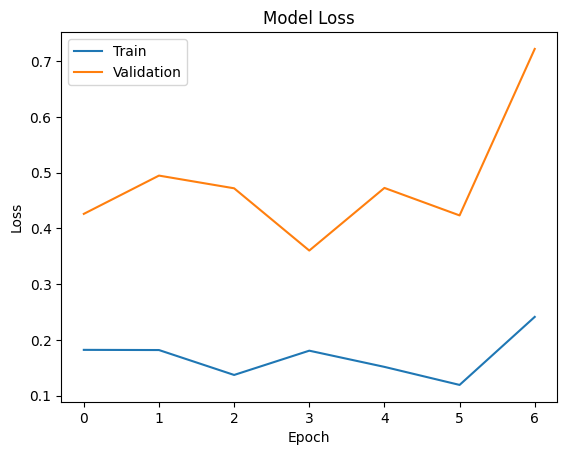

In [28]:
# 훈련 및 검증 손실을 시각화
plt.plot(history.history['loss'], label='Train Loss') # 훈련 손실(train loss)을 그래프에 추가
plt.plot(history.history['val_loss'], label='Validation Loss') # 검증 손실(validation loss)을 그래프에 추가
plt.title('Model Loss') # 그래프 제목 설정
plt.ylabel('Loss') # y 축 레이블 설정
plt.xlabel('Epoch') # x 축 레이블 설정
plt.legend(['Train', 'Validation'], loc='upper left') # 범례(legend) 추가 (훈련 손실과 검증 손실에 대한 레이블 표시)
plt.show() # 그래프를 화면에 출력

In [29]:
# 모델 평가

# 테스트 손실(test loss)과 테스트 정확도(test accuracy)를 계산
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the BiLSTM model:", test_accuracy) # 모델의 정확도를 출력
predictions = model.predict(testX) # 모델을 사용하여 테스트 데이터에 대한 예측을 수행

Accuracy of the BiLSTM model: 0.8853070735931396
93/93 [==============================] - 3s 26ms/step


In [30]:
predictions

array([[3.6287788e-04, 2.7156459e-05, 9.2803448e-06, 2.2642028e-03,
        9.9733353e-01, 3.0033225e-06],
       [1.8933632e-04, 1.8530371e-05, 4.9728960e-06, 1.9363250e-03,
        9.9784851e-01, 2.3304740e-06],
       [1.7612110e-04, 1.7419236e-05, 4.7216531e-06, 1.8994531e-03,
        9.9790013e-01, 2.1262601e-06],
       ...,
       [7.0259717e-05, 9.9922740e-01, 7.0169149e-04, 9.9360975e-08,
        2.7666445e-07, 1.9454862e-07],
       [1.7504772e-04, 9.8800069e-01, 1.1801297e-02, 5.7961124e-06,
        8.7540639e-06, 8.4163730e-06],
       [1.4382334e-04, 9.9479502e-01, 5.0520794e-03, 1.8510409e-06,
        3.0739100e-06, 4.2049519e-06]], dtype=float32)

In [31]:
# 분류 결과 시각화 및 출력 함수 정의

def display_results(testy, predictions, classNames):
    # 정답 레이블과 모델의 예측 결과를 각각의 클래스 인덱스로 변환
    y_test = np.argmax(testy, axis=1)
    y_scores = np.argmax(predictions, axis=1)
    classes = len(classNames) # 클래스의 개수를 계산
    cm = confusion_matrix(y_test, y_scores) # 혼동 행렬을 계산
    
    # 혼동 행렬 출력
    print("**** Confusion Matrix ****")
    print(cm)
    
    # 분류 보고서 출력
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    
    # 혼동 행렬 시각화
    con = np.zeros((classes, classes))
    for x in range(classes):
        for y in range(classes):
            con[x, y] = cm[x, y]  # 혼동 행렬의 값
    
    plt.figure(figsize=(10, 8))
    
    # seaborn을 사용하여 혼동 행렬을 열람합니다.
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues', xticklabels=classNames, yticklabels=classNames)
    plt.xlabel('Predicted')  # x 축 레이블
    plt.ylabel('Actual')  # y 축 레이블
    plt.show() # 그래프를 화면에 출력

**** Confusion Matrix ****
[[489   5   2   0   0   0]
 [  4 445  22   0   0   0]
 [ 16  19 385   0   0   0]
 [  0  25   0 410  56   0]
 [  0   2   0 101 429   0]
 [  0  43   0   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.96      0.99      0.97       496
           2       0.83      0.94      0.88       471
           3       0.94      0.92      0.93       420
           4       0.80      0.84      0.82       491
           5       0.88      0.81      0.84       532
           6       1.00      0.92      0.96       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



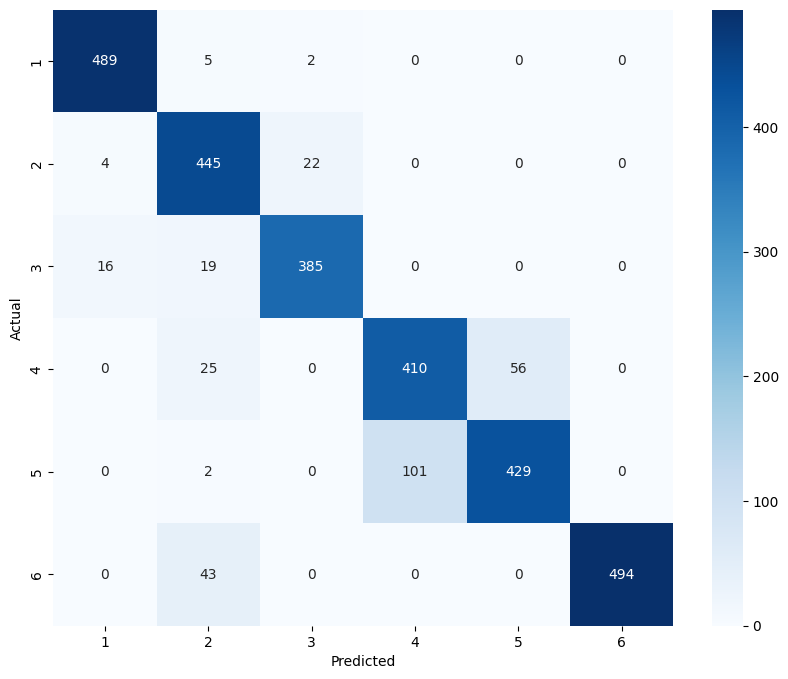

In [20]:
classNames = ["1", "2", "3", "4", "5", "6"] # classNames = 레이블
display_results(testy, predictions, classNames) # 분류 결과를 시각화, 출력

# GRU

In [32]:
# Sequential 모델 생성
model_GRU = Sequential()

# GRU 레이어 추가: 100개의 유닛을 가지며 입력 형태는 (n_timesteps, n_features)
model_GRU.add(GRU(100, input_shape=(n_timesteps, n_features)))

# 드롭아웃 레이어 추가: 오버피팅을 방지하기 위해 50%의 드롭아웃 적용
model_GRU.add(Dropout(0.5))

# 완전 연결 레이어 추가: 100개의 유닛을 가지며 활성화 함수: ReLU
model_GRU.add(Dense(100, activation='relu'))

# 출력 레이어 추가: 출력 클래스 수에 해당하는 뉴런 수와 소프트맥스 활성화 함수
model_GRU.add(Dense(n_outputs, activation='softmax'))

# 모델 요약 정보 출력
model_GRU.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100)               33300     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 6)                 606       
                                                                 
Total params: 44006 (171.90 KB)
Trainable params: 44006 (171.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
model_GRU.compile(
    loss='categorical_crossentropy',  # 손실 함수 설정
    optimizer='adam',                # 옵티마이저 설정
    metrics=['accuracy']             # 평가 지표 설정
)

In [34]:
# 네트워크를 훈련

train_epochs = 7
history_GRU = model_GRU.fit( # 모델을 훈련하고 히스토리 정보를 저장
    trainX,           # 훈련 데이터
    trainy,           # 훈련 데이터의 레이블
    epochs=train_epochs,  # 에포크 수
    batch_size=batch_size,  # 미니배치 크기
    verbose=True,          # 훈련 과정을 출력
    validation_split=validation_split,  # 검증 데이터 비율
    shuffle=True           # 데이터를 무작위로 셔플
)

Epoch 1/7
92/92 [==============================] - 13s 123ms/step - loss: 1.2426 - accuracy: 0.4775 - val_loss: 1.1876 - val_accuracy: 0.5330
Epoch 2/7
92/92 [==============================] - 9s 94ms/step - loss: 0.9591 - accuracy: 0.5967 - val_loss: 1.0368 - val_accuracy: 0.5806
Epoch 3/7
92/92 [==============================] - 8s 90ms/step - loss: 0.6832 - accuracy: 0.7182 - val_loss: 0.5878 - val_accuracy: 0.7797
Epoch 4/7
92/92 [==============================] - 8s 90ms/step - loss: 0.4385 - accuracy: 0.8250 - val_loss: 0.4160 - val_accuracy: 0.8600
Epoch 5/7
92/92 [==============================] - 9s 93ms/step - loss: 0.2879 - accuracy: 0.8978 - val_loss: 0.3418 - val_accuracy: 0.8953
Epoch 6/7
92/92 [==============================] - 8s 89ms/step - loss: 0.2084 - accuracy: 0.9238 - val_loss: 0.3196 - val_accuracy: 0.9001
Epoch 7/7
92/92 [==============================] - 8s 89ms/step - loss: 0.1716 - accuracy: 0.9378 - val_loss: 0.2530 - val_accuracy: 0.9150


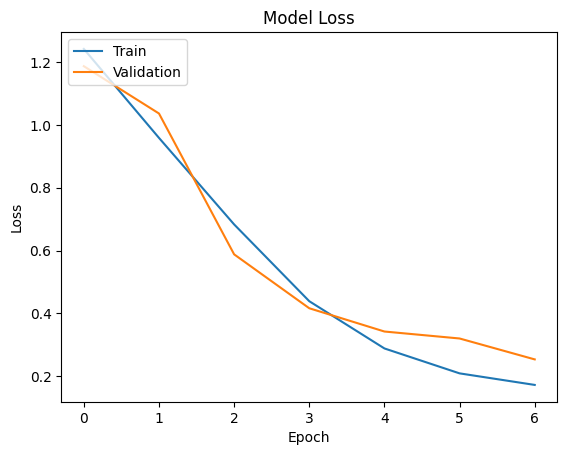

In [35]:
# 훈련 및 검증 손실을 시각화
plt.plot(history_GRU.history['loss'], label='Train Loss') # 훈련 손실(train loss)을 그래프에 추가
plt.plot(history_GRU.history['val_loss'], label='Validation Loss') # 검증 손실(validation loss)을 그래프에 추가
plt.title('Model Loss') # 그래프 제목 설정
plt.ylabel('Loss') # y 축 레이블 설정
plt.xlabel('Epoch') # x 축 레이블 설정
plt.legend(['Train', 'Validation'], loc='upper left') # 범례(legend) 추가 (훈련 손실과 검증 손실에 대한 레이블 표시)

In [36]:
# 모델 평가

# 테스트 손실(test loss)과 테스트 정확도(test accuracy)를 계산
test_loss, test_accuracy = model_GRU.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the GRU model:", test_accuracy) # 모델의 정확도를 출력
predictions = model_GRU.predict(testX) # 모델을 사용하여 테스트 데이터에 대한 예측을 수행

Accuracy of the GRU model: 0.8863250613212585
93/93 [==============================] - 2s 14ms/step


In [37]:
predictions

array([[1.1259493e-02, 6.3185071e-05, 6.8092268e-05, 3.1878951e-03,
        9.8542124e-01, 6.4831205e-08],
       [4.9729175e-03, 4.6246161e-05, 5.5289478e-05, 5.2779680e-03,
        9.8964745e-01, 9.7075421e-08],
       [4.1237967e-03, 4.3890221e-05, 5.5847027e-05, 6.2496518e-03,
        9.8952675e-01, 1.1123281e-07],
       ...,
       [1.0037696e-03, 9.9617910e-01, 2.8169516e-03, 3.4678397e-08,
        2.0361301e-07, 4.0526280e-09],
       [2.0981843e-03, 9.9434340e-01, 3.5560532e-03, 2.8004698e-07,
        2.1151809e-06, 6.8451847e-08],
       [2.4082665e-03, 9.9692684e-01, 6.6386745e-04, 3.2533212e-08,
        1.0814366e-06, 2.9764829e-08]], dtype=float32)

In [38]:
# 분류 결과 시각화 및 출력 함수 정의

def display_results(testy, predictions, classNames):
    # 정답 레이블과 모델의 예측 결과를 각각의 클래스 인덱스로 변환
    y_test = np.argmax(testy, axis=1)
    y_scores = np.argmax(predictions, axis=1)
    classes = len(classNames) # 클래스의 개수를 계산
    cm = confusion_matrix(y_test, y_scores) # 혼동 행렬을 계산
    
    # 혼동 행렬 출력
    print("**** Confusion Matrix ****")
    print(cm)
    
    # 분류 보고서 출력
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    
    # 혼동 행렬 시각화
    con = np.zeros((classes, classes))
    for x in range(classes):
        for y in range(classes):
            con[x, y] = cm[x, y]  # 혼동 행렬의 값
    
    plt.figure(figsize=(10, 8))
    
    # seaborn을 사용하여 혼동 행렬을 열람합니다.
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues', xticklabels=classNames, yticklabels=classNames)
    plt.xlabel('Predicted')  # x 축 레이블
    plt.ylabel('Actual')  # y 축 레이블
    plt.show() # 그래프를 화면에 출력

**** Confusion Matrix ****
[[430   8  58   0   0   0]
 [  4 422  44   0   1   0]
 [  1   0 419   0   0   0]
 [ 16   6   1 411  57   0]
 [ 14   1   0  97 420   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.92      0.87      0.89       496
           2       0.91      0.90      0.90       471
           3       0.80      1.00      0.89       420
           4       0.81      0.84      0.82       491
           5       0.88      0.79      0.83       532
           6       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



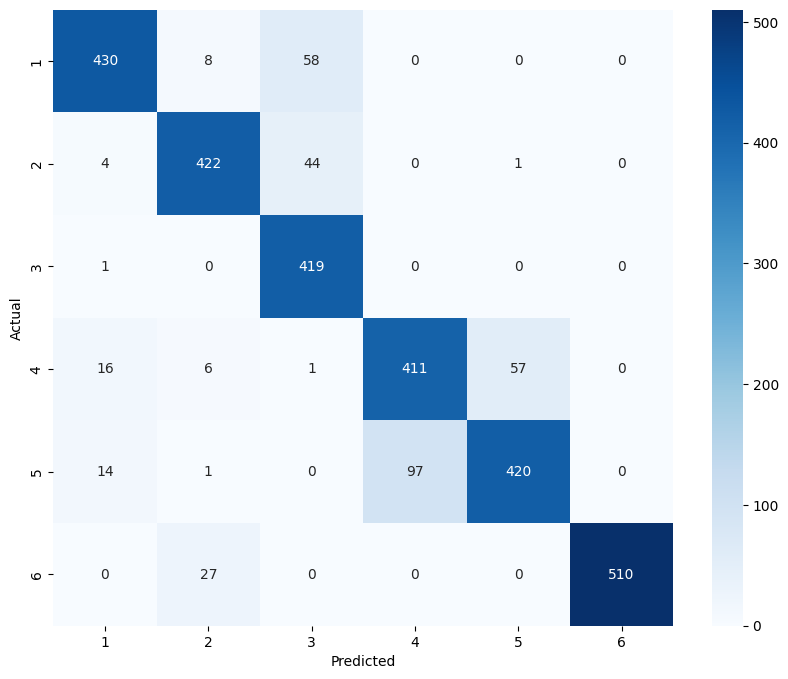

In [39]:
classNames = ["1", "2", "3", "4", "5", "6"] # classNames = 레이블
display_results(testy, predictions, classNames) # 분류 결과를 시각화, 출력

# BiGRU

In [40]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model_BiGRU = Sequential() # Sequential 모델 생성

# BiGRU 레이어 추가: 100개의 유닛을 가지며 입력 형태는 (n_timesteps, n_features)
model_BiGRU.add(GRU(100, input_shape=(n_timesteps, n_features)))

# 드롭아웃 레이어 추가: 오버피팅을 방지하기 위해 50%의 드롭아웃 적용
model_BiGRU.add(Dropout(0.5))

# 완전 연결 레이어 추가: 100개의 유닛을 가지며 활성화 함수: ReLU
model_BiGRU.add(Dense(100, activation='relu'))

# 출력 레이어 추가: 출력 클래스 수에 해당하는 뉴런 수와 소프트맥스 활성화 함수
model_BiGRU.add(Dense(n_outputs, activation='softmax'))

# 모델 요약 정보 출력
model_BiGRU.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 100)               33300     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 6)                 606       
                                                                 
Total params: 44006 (171.90 KB)
Trainable params: 44006 (171.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
model_BiGRU.compile(
    loss='categorical_crossentropy',  # 손실 함수 설정
    optimizer='adam',                # 옵티마이저 설정
    metrics=['accuracy']             # 평가 지표 설정
)

In [42]:
# 네트워크를 훈련

train_epochs = 7
history_BiGRU = model_BiGRU.fit( # 모델을 훈련하고 히스토리 정보를 저장
    trainX,           # 훈련 데이터
    trainy,           # 훈련 데이터의 레이블
    epochs=train_epochs,  # 에포크 수
    batch_size=batch_size,  # 미니배치 크기
    verbose=True,          # 훈련 과정을 출력
    validation_split=validation_split,  # 검증 데이터 비율
    shuffle=True           # 데이터를 무작위로 셔플
)

Epoch 1/7
92/92 [==============================] - 10s 89ms/step - loss: 1.2988 - accuracy: 0.4591 - val_loss: 1.0528 - val_accuracy: 0.6044
Epoch 2/7
92/92 [==============================] - 8s 91ms/step - loss: 0.8168 - accuracy: 0.6429 - val_loss: 0.7714 - val_accuracy: 0.7206
Epoch 3/7
92/92 [==============================] - 8s 88ms/step - loss: 0.6057 - accuracy: 0.7458 - val_loss: 0.5324 - val_accuracy: 0.8151
Epoch 4/7
92/92 [==============================] - 8s 88ms/step - loss: 0.4253 - accuracy: 0.8390 - val_loss: 0.3242 - val_accuracy: 0.9055
Epoch 5/7
92/92 [==============================] - 8s 90ms/step - loss: 0.2399 - accuracy: 0.9162 - val_loss: 0.2539 - val_accuracy: 0.9137
Epoch 6/7
92/92 [==============================] - 8s 89ms/step - loss: 0.2001 - accuracy: 0.9260 - val_loss: 0.5017 - val_accuracy: 0.8035
Epoch 7/7
92/92 [==============================] - 8s 90ms/step - loss: 0.1736 - accuracy: 0.9347 - val_loss: 0.2442 - val_accuracy: 0.9069


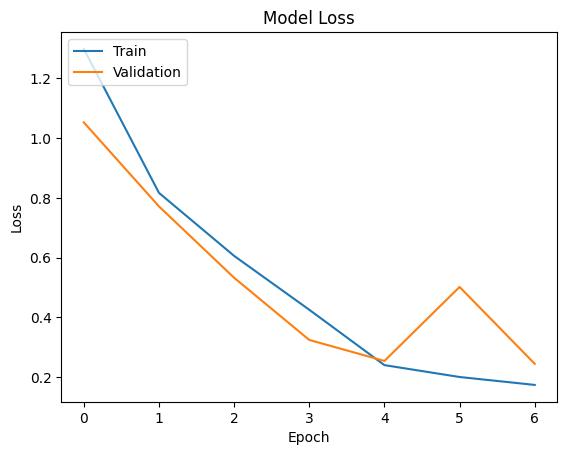

In [43]:
# 훈련 및 검증 손실을 시각화
plt.plot(history_BiGRU.history['loss'], label='Train Loss') # 훈련 손실(train loss)을 그래프에 추가
plt.plot(history_BiGRU.history['val_loss'], label='Validation Loss') # 검증 손실(validation loss)을 그래프에 추가
plt.title('Model Loss') # 그래프 제목 설정
plt.ylabel('Loss') # y 축 레이블 설정
plt.xlabel('Epoch') # x 축 레이블 설정
plt.legend(['Train', 'Validation'], loc='upper left') # 범례(legend) 추가 (훈련 손실과 검증 손실에 대한 레이블 표시)

In [44]:
predictions

array([[1.1259493e-02, 6.3185071e-05, 6.8092268e-05, 3.1878951e-03,
        9.8542124e-01, 6.4831205e-08],
       [4.9729175e-03, 4.6246161e-05, 5.5289478e-05, 5.2779680e-03,
        9.8964745e-01, 9.7075421e-08],
       [4.1237967e-03, 4.3890221e-05, 5.5847027e-05, 6.2496518e-03,
        9.8952675e-01, 1.1123281e-07],
       ...,
       [1.0037696e-03, 9.9617910e-01, 2.8169516e-03, 3.4678397e-08,
        2.0361301e-07, 4.0526280e-09],
       [2.0981843e-03, 9.9434340e-01, 3.5560532e-03, 2.8004698e-07,
        2.1151809e-06, 6.8451847e-08],
       [2.4082665e-03, 9.9692684e-01, 6.6386745e-04, 3.2533212e-08,
        1.0814366e-06, 2.9764829e-08]], dtype=float32)

In [45]:
# 분류 결과 시각화 및 출력 함수 정의

def display_results(testy, predictions, classNames):
    # 정답 레이블과 모델의 예측 결과를 각각의 클래스 인덱스로 변환
    y_test = np.argmax(testy, axis=1)
    y_scores = np.argmax(predictions, axis=1)
    classes = len(classNames) # 클래스의 개수를 계산
    cm = confusion_matrix(y_test, y_scores) # 혼동 행렬을 계산
    
    # 혼동 행렬 출력
    print("**** Confusion Matrix ****")
    print(cm)
    
    # 분류 보고서 출력
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    
    # 혼동 행렬 시각화
    con = np.zeros((classes, classes))
    for x in range(classes):
        for y in range(classes):
            con[x, y] = cm[x, y]  # 혼동 행렬의 값
    
    plt.figure(figsize=(10, 8))
    
    # seaborn을 사용하여 혼동 행렬을 열람합니다.
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues', xticklabels=classNames, yticklabels=classNames)
    plt.xlabel('Predicted')  # x 축 레이블
    plt.ylabel('Actual')  # y 축 레이블
    plt.show() # 그래프를 화면에 출력

**** Confusion Matrix ****
[[430   8  58   0   0   0]
 [  4 422  44   0   1   0]
 [  1   0 419   0   0   0]
 [ 16   6   1 411  57   0]
 [ 14   1   0  97 420   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.92      0.87      0.89       496
           2       0.91      0.90      0.90       471
           3       0.80      1.00      0.89       420
           4       0.81      0.84      0.82       491
           5       0.88      0.79      0.83       532
           6       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



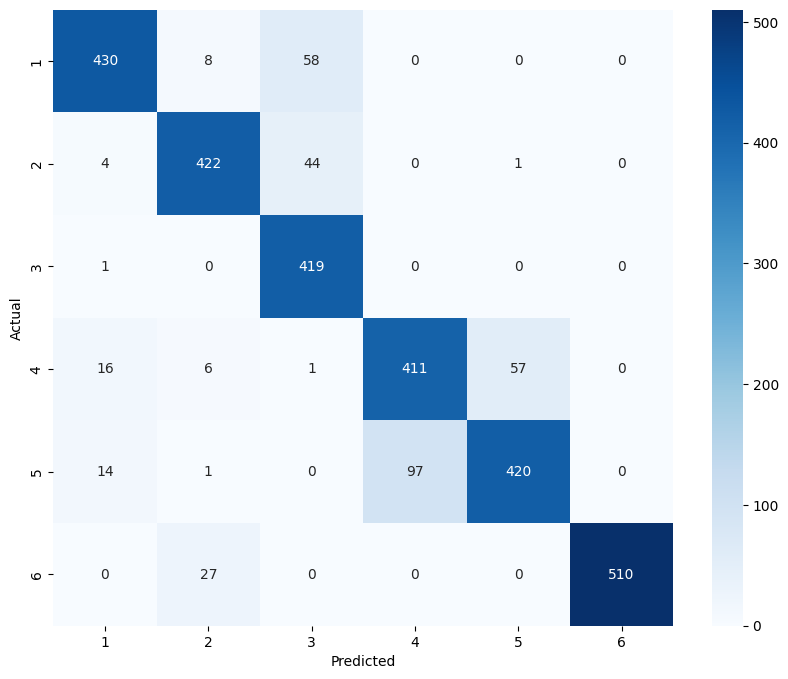

In [46]:
classNames = ["1", "2", "3", "4", "5", "6"] # classNames = 레이블
display_results(testy, predictions, classNames) # 분류 결과를 시각화, 출력